# Quy trình của chúng ta sẽ bao gồm:

Khởi tạo và Tải dữ liệu: Chuẩn bị các thư viện cần thiết và làm quen với bộ dữ liệu Palmer Penguins.

Tiền xử lý và Khám phá: "Dọn dẹp" dữ liệu và xác định các đặc trưng.

Kiểm tra phân bổ lớp: Trực quan hóa để đảm bảo việc chia dữ liệu là hợp lý.

Thí nghiệm với các tỷ lệ chia: Xây dựng và đánh giá mô hình với 4 kịch bản chia dữ liệu khác nhau.

Phân tích độ sâu của cây: Khám phá xem độ sâu ảnh hưởng đến độ chính xác của mô hình như thế nào.

## 1. Khởi tạo và Tải dữ liệu

In [ ]:
# ====== Nhập các thư viện cần thiết ======
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pydataset import data # Thư viện để tải dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.impute import SimpleImputer
import graphviz
import os
import matplotlib.font_manager
from sklearn.impute import SimpleImputer 



# ====== Tải dữ liệu Palmer Penguins ======
penguins_df = sns.load_dataset('penguins')

print("\n====== 5 dòng dữ liệu đầu tiên ======")
print(penguins_df.head())
print("\n====== Thông tin tổng quan của dữ liệu ======")
penguins_df.info()




====== 5 dòng dữ liệu đầu tiên ======
  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
3          NaN     NaN  
4       3450.0  Female  

====== Thông tin tổng quan của dữ liệu ======
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm    

## 2. Tiền xử lý và Khám phá dữ liệu
Với bộ dữ liệu chim cánh cụt, chúng ta cần:

Xử lý giá trị thiếu (NaN): loại bỏ các hàng bị thiếu (vì số hàng bị thiếu là khá ít 11 trên 344 hàng)

Xác định Đặc trưng (X) và Nhãn (y):

X: Là tất cả các cột chứa thông tin về con chim cánh cụt (độ dài mỏ, cân nặng, giới tính,...) mà chúng ta sẽ dùng để dự đoán.

y: Là cột species (loài), đây chính là thứ chúng ta muốn mô hình dự đoán.

Phân loại các cột: Chúng ta cần phân biệt đâu là cột chứa dữ liệu dạng số (numerical) và đâu là cột chứa dữ liệu dạng phân loại (categorical) để có thể áp dụng các kỹ thuật xử lý phù hợp ở các bước sau.

In [7]:
# ====== Xử lý dữ liệu bị thiếu ======
# Kiểm tra xem có bao nhiêu giá trị bị thiếu trong mỗi cột
print("Số lượng giá trị thiếu trước khi xử lý:")
print(penguins_df.isnull().sum())

# Vì số lượng hàng bị thiếu ít, ta sẽ loại bỏ chúng
penguins_df_cleaned = penguins_df.dropna()
print("\nKích thước dữ liệu sau khi loại bỏ các hàng bị thiếu:", penguins_df_cleaned.shape)

# ====== Tách Đặc trưng (X) và Nhãn (y) ======
X = penguins_df_cleaned.drop('species', axis=1)
y = penguins_df_cleaned['species']
# Lấy tên các loài chim cánh cụt để dùng trong các biểu đồ sau này
class_names = y.unique().tolist()
print("\nCác loài chim (nhãn):", class_names)


# ====== Phân loại các cột thành Numerical và Categorical ======
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()

print("\nCác cột category:", categorical_cols)
print("Các cột numeric:", numerical_cols)


Số lượng giá trị thiếu trước khi xử lý:
species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

Kích thước dữ liệu sau khi loại bỏ các hàng bị thiếu: (333, 7)

Các loài chim (nhãn): ['Adelie', 'Chinstrap', 'Gentoo']

Các cột category: ['island', 'sex']
Các cột numeric: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']


## 3. Trực quan hóa Phân bổ Lớp 
Đề bài yêu cầu chúng ta phải chia dataset in a stratified fashion. Điều này có nghĩa là tỷ lệ các lớp (3 loài chim cánh cụt) phải được giữ nguyên trong cả tập huấn luyện và tập kiểm tra so với tập dữ liệu ban đầu.

Để chứng minh rằng chúng ta đã làm đúng, chúng ta cần vẽ biểu đồ phân bổ số lượng của từng loài chim trong các tập dữ liệu này. Nếu các biểu đồ trông tương tự nhau về mặt tỷ lệ, nghĩa là việc chia dữ liệu đã thành công.

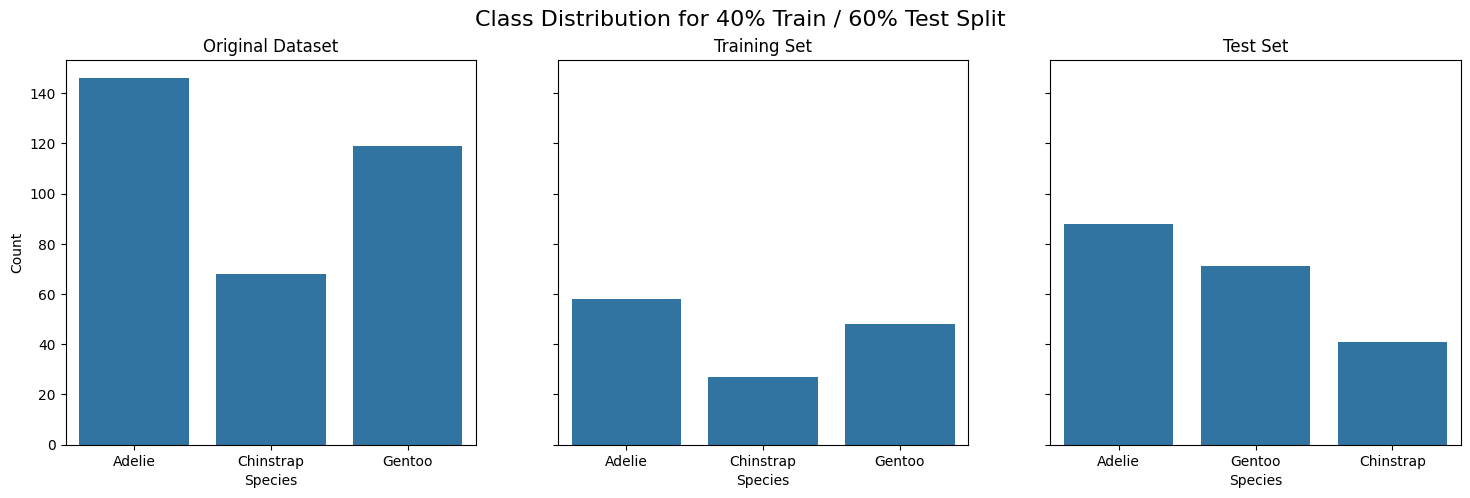

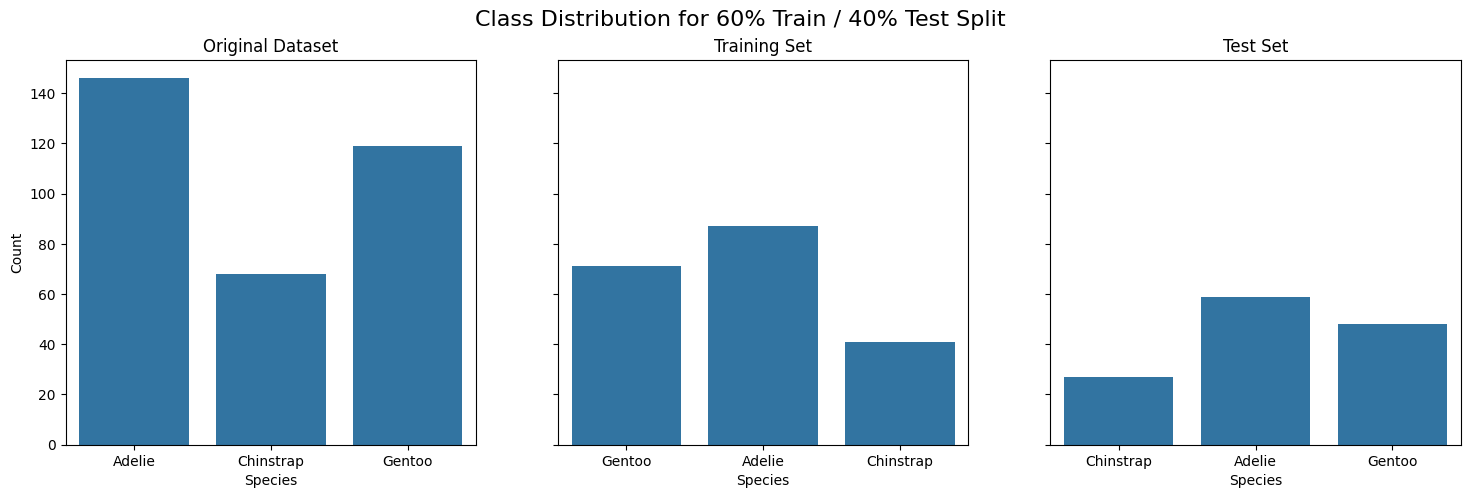

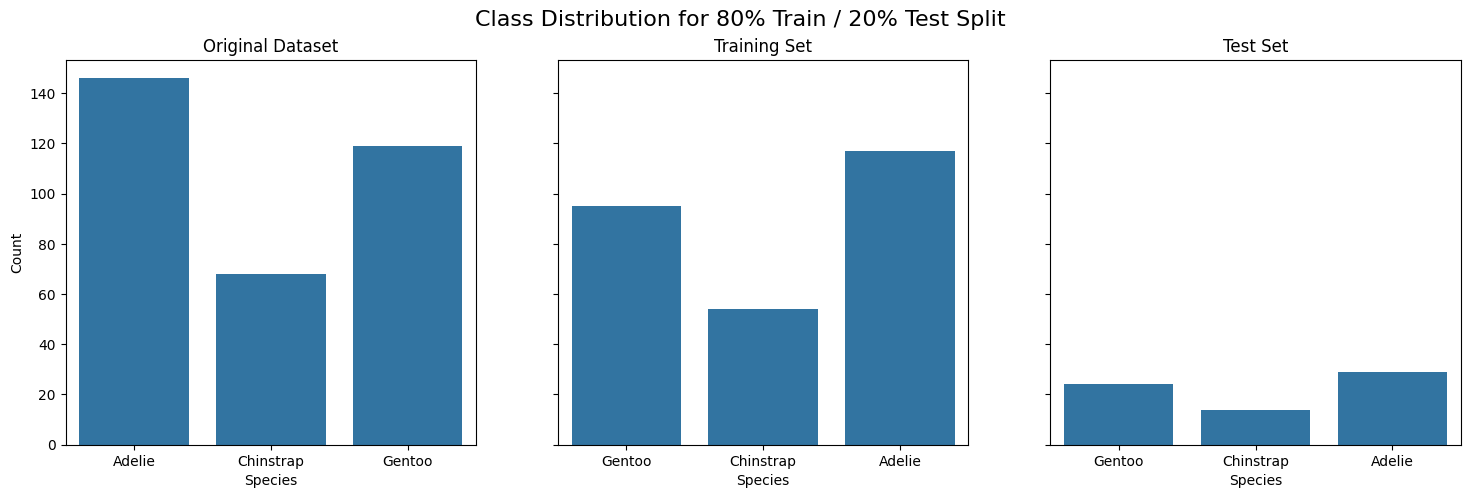

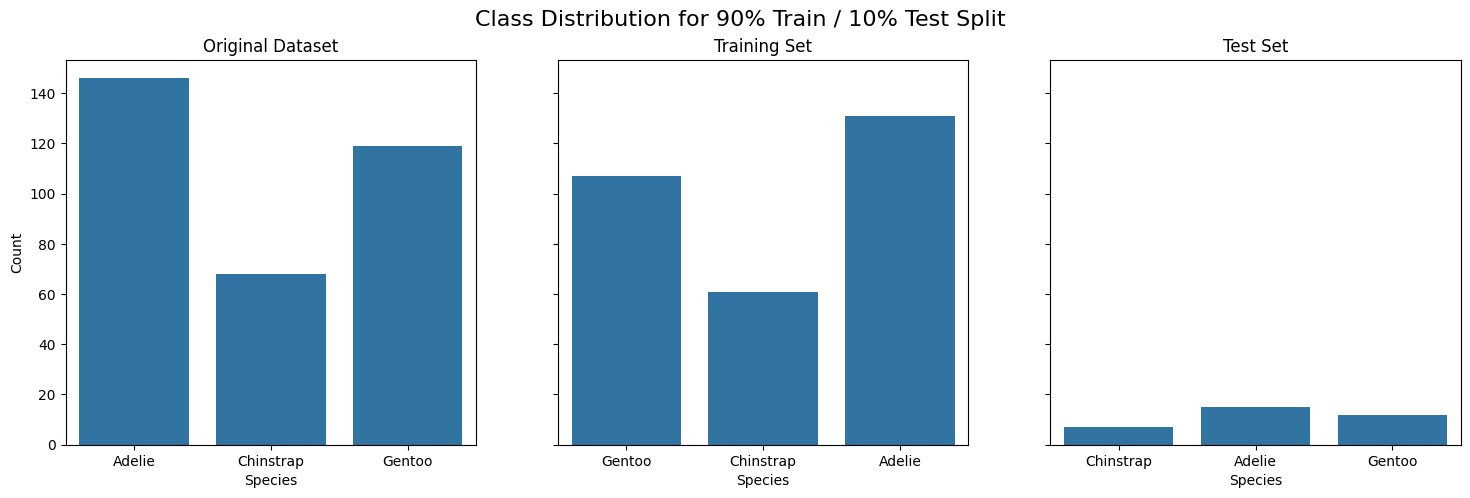

In [8]:
# Các tỷ lệ chia train/test theo yêu cầu
split_ratios = [(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]

# Vẽ biểu đồ cho từng tỷ lệ chia
for train_size, test_size in split_ratios:
    # Chia dữ liệu với stratified=y
    feature_train, feature_test, label_train, label_test = train_test_split(
        X, y, train_size=train_size, random_state=42, stratify=y
    )

    # Tạo figure để chứa 3 biểu đồ con
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    # SỬA LỖI FONT: Chuyển tiêu đề sang tiếng Anh
    fig.suptitle(f'Class Distribution for {int(train_size*100)}% Train / {int(test_size*100)}% Test Split', fontsize=16)

    # Biểu đồ cho tập dữ liệu gốc
    sns.countplot(ax=axes[0], x=y)
    axes[0].set_title('Original Dataset')
    axes[0].set_xlabel('Species')
    axes[0].set_ylabel('Count')


    # Biểu đồ cho tập huấn luyện
    sns.countplot(ax=axes[1], x=label_train)
    axes[1].set_title('Training Set')
    axes[1].set_xlabel('Species')
    axes[1].set_ylabel('') # Ẩn nhãn y

    # Biểu đồ cho tập kiểm tra
    sns.countplot(ax=axes[2], x=label_test)
    axes[2].set_title('Test Set')
    axes[2].set_xlabel('Species')
    axes[2].set_ylabel('') # Ẩn nhãn y

    plt.show()


## 4. Thí nghiệm với các Tỷ lệ chia 
Đây là phần chính của thí nghiệm. Chúng ta sẽ lặp lại quy trình sau cho mỗi tỷ lệ chia (40/60, 60/40,...):

Xây dựng Pipeline:

Tiền xử lý: Các cột số sẽ được điền giá trị thiếu bằng giá trị trung bình. Các cột phân loại sẽ được điền giá trị thiếu bằng giá trị xuất hiện nhiều nhất, sau đó được One-Hot encoding.

Mô hình: Sử dụng DecisionTreeClassifier. Lưu ý quan trọng: Đề bài yêu cầu dùng tiêu chí Information Gain, vì vậy chúng ta phải thiết lập criterion='entropy'.

Huấn luyện và Đánh giá:

Huấn luyện pipeline trên tập train.

Dùng mô hình đã học để dự đoán trên tập test.

Hiển thị Báo cáo phân loại và Ma trận nhầm lẫn để xem mô hình hoạt động hiệu quả ra sao.

Trực quan hóa cây:

Vẽ ra cây quyết định tương ứng với mỗi tỷ lệ chia để hiểu cách mô hình đưa ra quyết định. Để cây dễ đọc, chúng ta sẽ giới hạn độ sâu của nó (= 4) trong phần trực quan hóa này.


   BẮT ĐẦU THÍ NGHIỆM VỚI TỶ LỆ: 40% TRAIN / 60% TEST

------ Báo cáo Phân loại ------
              precision    recall  f1-score   support

      Adelie       0.99      0.93      0.96        88
   Chinstrap       0.85      0.98      0.91        41
      Gentoo       1.00      0.99      0.99        71

    accuracy                           0.96       200
   macro avg       0.95      0.96      0.95       200
weighted avg       0.96      0.96      0.96       200


------ Ma trận Nhầm lẫn ------


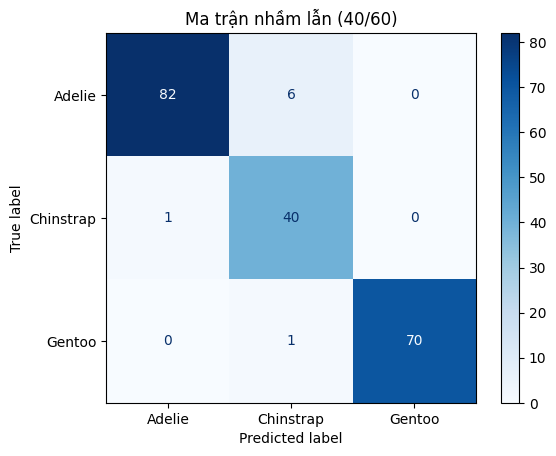


------ Cây Quyết định (Độ sâu=4, Tỷ lệ 40/60) ------


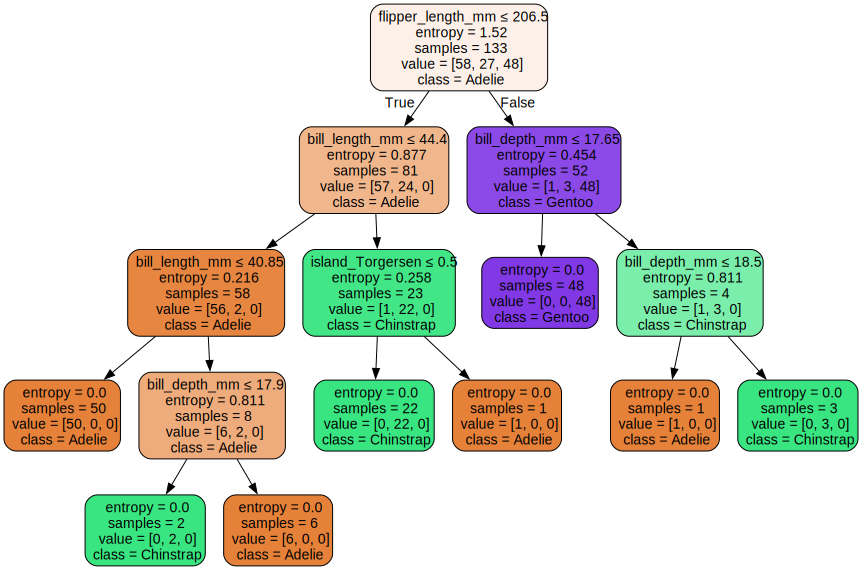


   BẮT ĐẦU THÍ NGHIỆM VỚI TỶ LỆ: 60% TRAIN / 40% TEST

------ Báo cáo Phân loại ------
              precision    recall  f1-score   support

      Adelie       1.00      0.95      0.97        59
   Chinstrap       0.84      1.00      0.92        27
      Gentoo       1.00      0.96      0.98        48

    accuracy                           0.96       134
   macro avg       0.95      0.97      0.96       134
weighted avg       0.97      0.96      0.96       134


------ Ma trận Nhầm lẫn ------


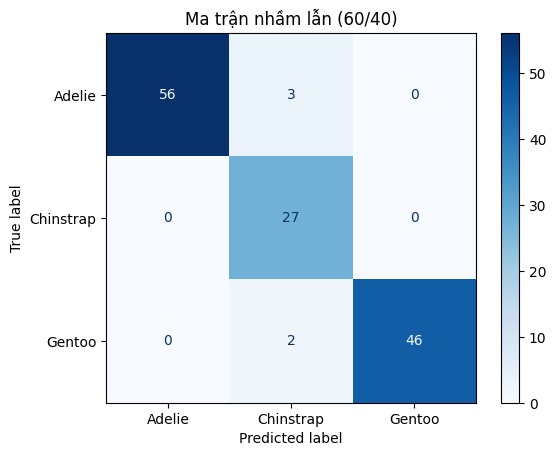


------ Cây Quyết định (Độ sâu=4, Tỷ lệ 60/40) ------


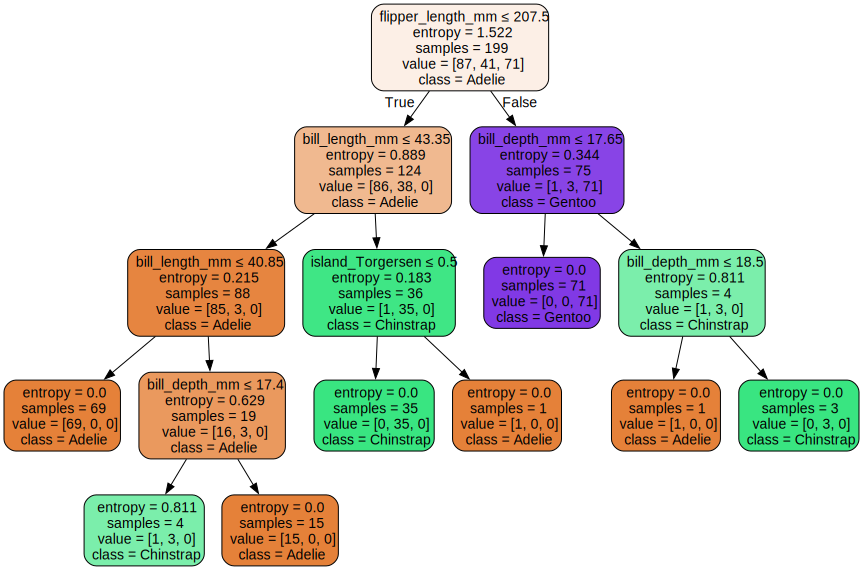


   BẮT ĐẦU THÍ NGHIỆM VỚI TỶ LỆ: 80% TRAIN / 20% TEST

------ Báo cáo Phân loại ------
              precision    recall  f1-score   support

      Adelie       0.94      1.00      0.97        29
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      0.92      0.96        24

    accuracy                           0.97        67
   macro avg       0.98      0.97      0.97        67
weighted avg       0.97      0.97      0.97        67


------ Ma trận Nhầm lẫn ------


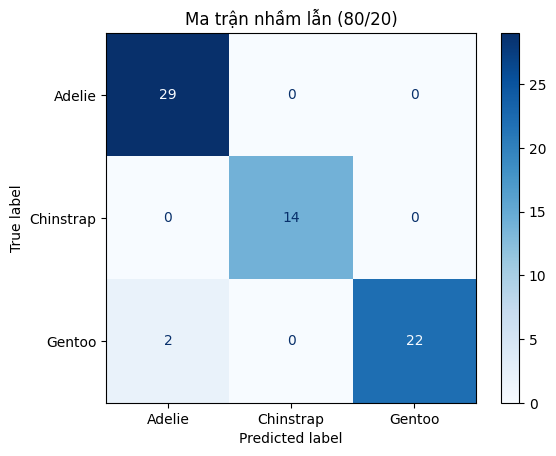


------ Cây Quyết định (Độ sâu=4, Tỷ lệ 80/20) ------


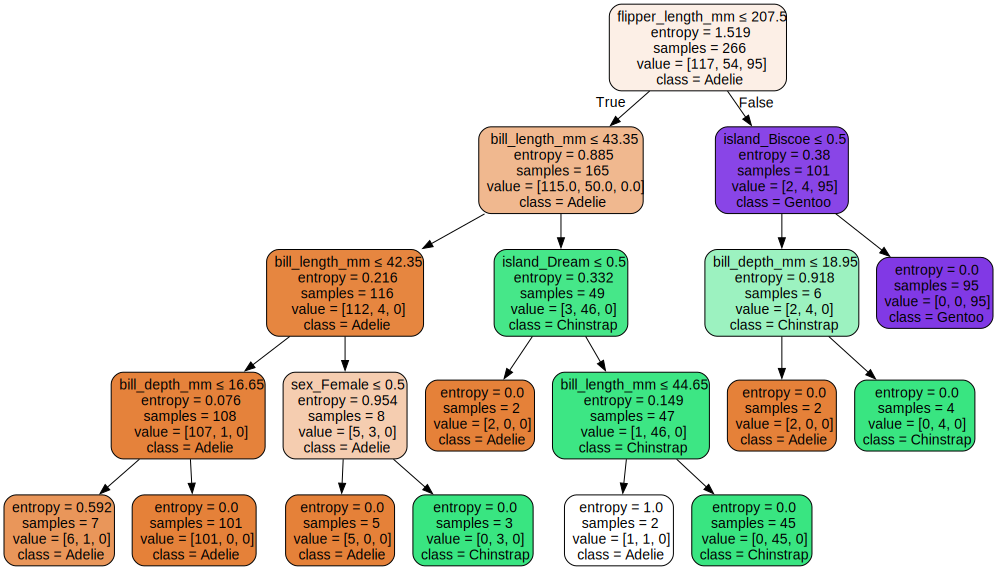


   BẮT ĐẦU THÍ NGHIỆM VỚI TỶ LỆ: 90% TRAIN / 10% TEST

------ Báo cáo Phân loại ------
              precision    recall  f1-score   support

      Adelie       0.88      1.00      0.94        15
   Chinstrap       1.00      1.00      1.00         7
      Gentoo       1.00      0.83      0.91        12

    accuracy                           0.94        34
   macro avg       0.96      0.94      0.95        34
weighted avg       0.95      0.94      0.94        34


------ Ma trận Nhầm lẫn ------


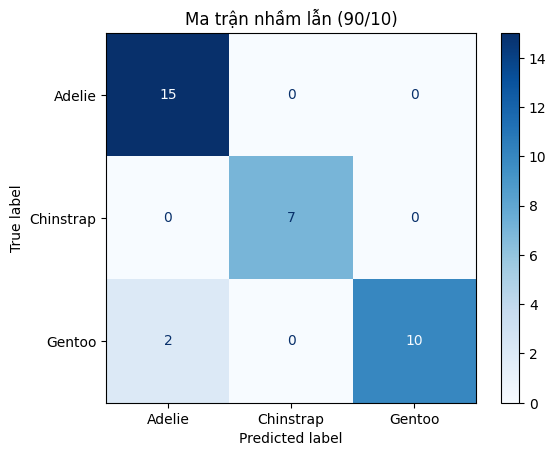


------ Cây Quyết định (Độ sâu=4, Tỷ lệ 90/10) ------


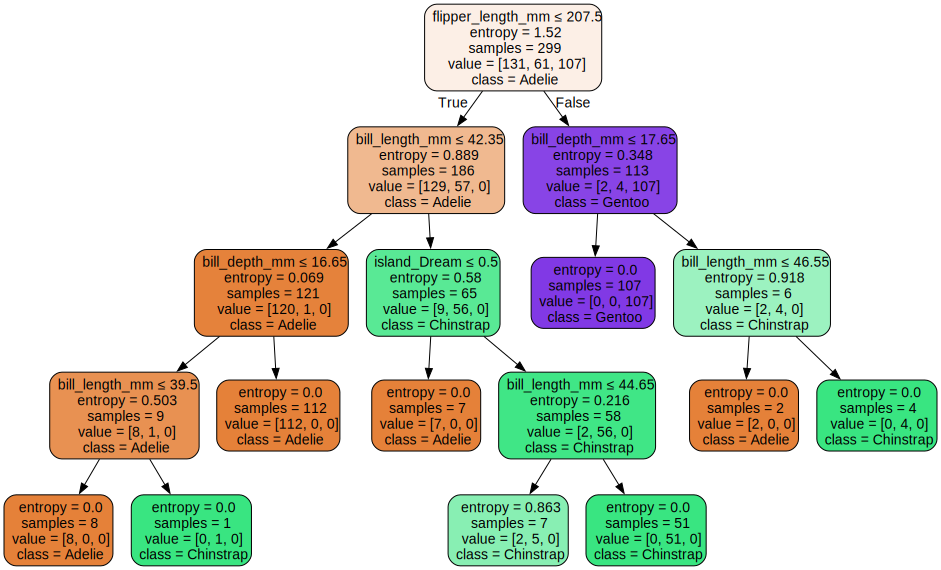

In [10]:
# ====== Xây dựng Pipeline Tiền xử lý và Mô hình ======

# Pipeline cho các cột số: chỉ cần điền giá trị thiếu
numerical_transformer = SimpleImputer(strategy='mean')

# Pipeline cho các cột phân loại: điền giá trị thiếu và mã hóa one-hot
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bộ tiền xử lý kết hợp cả hai pipeline trên
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Hàm để xây dựng pipeline hoàn chỉnh
def build_pipeline(max_depth=None):
    return Pipeline([
        ("preprocessor", preprocessor),
        # QUAN TRỌNG: Sử dụng criterion='entropy' theo yêu cầu đề bài
        ("classifier", DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42))
    ])

# ====== Thực hiện Vòng lặp Thí nghiệm ======

for train_size, test_size in split_ratios:
    print(f"\n=======================================================================")
    print(f"   BẮT ĐẦU THÍ NGHIỆM VỚI TỶ LỆ: {int(train_size*100)}% TRAIN / {int(test_size*100)}% TEST")
    print(f"=======================================================================\n")

    # Chia dữ liệu
    feature_train, feature_test, label_train, label_test = train_test_split(
        X, y, train_size=train_size, random_state=42, stratify=y
    )

    # Xây dựng và huấn luyện mô hình (giới hạn độ sâu là 4 để cây dễ nhìn)
    model = build_pipeline(max_depth=4)
    model.fit(feature_train, label_train)
    label_pred = model.predict(feature_test)

    # ====== Hiển thị Báo cáo Phân loại và Ma trận Nhầm lẫn (Yêu cầu 2.3) ======
    print("------ Báo cáo Phân loại ------")
    print(classification_report(label_test, label_pred, target_names=class_names))

    print("\n------ Ma trận Nhầm lẫn ------")
    cm = confusion_matrix(label_test, label_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues")
    plt.title(f"Ma trận nhầm lẫn ({int(train_size*100)}/{int(test_size*100)})")
    plt.show()

    # ====== Trực quan hóa Cây Quyết định (Yêu cầu 2.2) ======
    # Lấy tên các đặc trưng sau khi đã được mã hóa one-hot
    feature_names_processed = numerical_cols + list(
        model.named_steps['preprocessor']
        .named_transformers_['cat']
        .named_steps['onehot']
        .get_feature_names_out(categorical_cols)
    )

    # Xuất dữ liệu DOT
    dot_data = export_graphviz(
        model.named_steps["classifier"],
        out_file=None,
        feature_names=feature_names_processed,
        class_names=sorted(y.unique()),
        filled=True,
        rounded=True,
        special_characters=True
    )
    
    # Vẽ và hiển thị đồ thị
    print(f"\n------ Cây Quyết định (Độ sâu=4, Tỷ lệ {int(train_size*100)}/{int(test_size*100)}) ------")
    graph = graphviz.Source(dot_data)
    # Lưu file ảnh ra thư mục hiện tại
    # graph.render(filename=f"penguins_tree_split_{int(train_size*100)}", format='png', cleanup=True)
    display(graph) # Hiển thị trực tiếp trong notebook




## 5. Phân tích Ảnh hưởng của Độ sâu Cây 
Phần này là một phân tích chuyên sâu hơn. Chúng ta sẽ cố định tỷ lệ chia là 80% huấn luyện / 20% kiểm tra và xem xét độ sâu (max_depth) của cây ảnh hưởng đến hiệu suất như thế nào.

max_depth thấp (ví dụ: 2, 3): Cây rất đơn giản, dễ hiểu nhưng có thể bỏ lỡ các quy luật phức tạp trong dữ liệu (underfitting).

max_depth cao (ví dụ: 6, 7): Cây rất phức tạp, có thể học thuộc lòng cả dữ liệu huấn luyện, dẫn đến dự đoán kém trên dữ liệu mới (overfitting).

max_depth = None: Cây sẽ phát triển cho đến khi mọi lá đều "thuần khiết" hoặc không thể chia được nữa. Đây là trường hợp dễ bị overfitting nhất.

Mục tiêu của chúng ta là tìm ra một độ sâu "vừa phải", nơi độ chính xác trên tập kiểm tra là cao nhất. Chúng ta sẽ:

Huấn luyện nhiều mô hình với các độ sâu khác nhau.

Lưu lại độ chính xác của từng mô hình.

Vẽ biểu đồ và lập bảng kết quả để tìm ra độ sâu tối ưu.

Bắt đầu thí nghiệm về độ sâu của cây trên tập 80/20...

Độ sâu = Tối đa (None), Độ chính xác trên tập Test = 0.9254
Cây quyết định với Độ sâu = Tối đa (None)


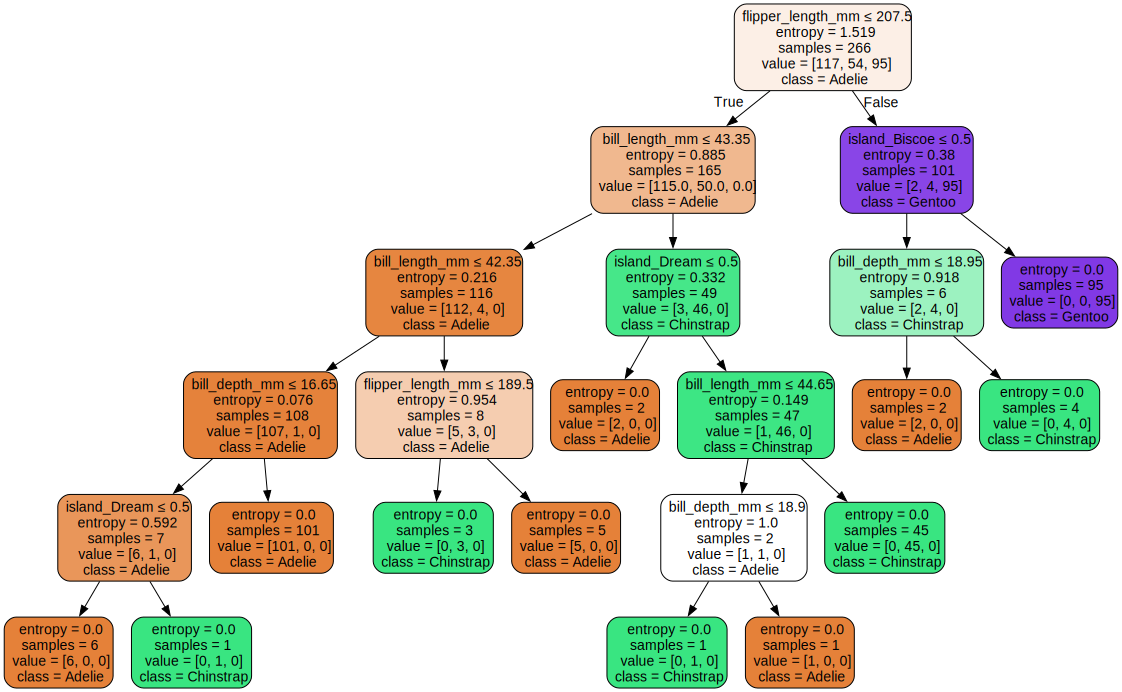

--------------------------------------------------
Độ sâu = 2, Độ chính xác trên tập Test = 0.9403
Cây quyết định với Độ sâu = 2


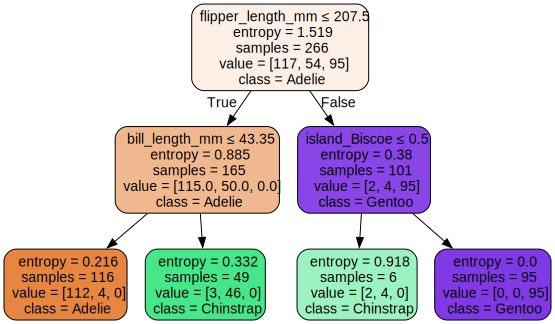

--------------------------------------------------
Độ sâu = 3, Độ chính xác trên tập Test = 0.9552
Cây quyết định với Độ sâu = 3


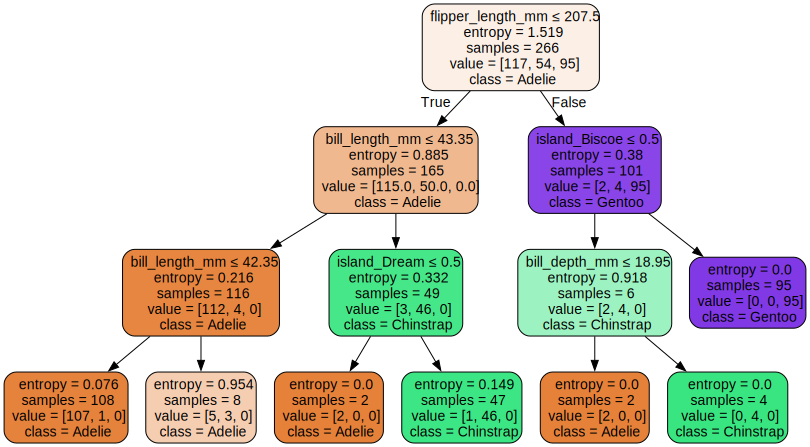

--------------------------------------------------
Độ sâu = 4, Độ chính xác trên tập Test = 0.9701
Cây quyết định với Độ sâu = 4


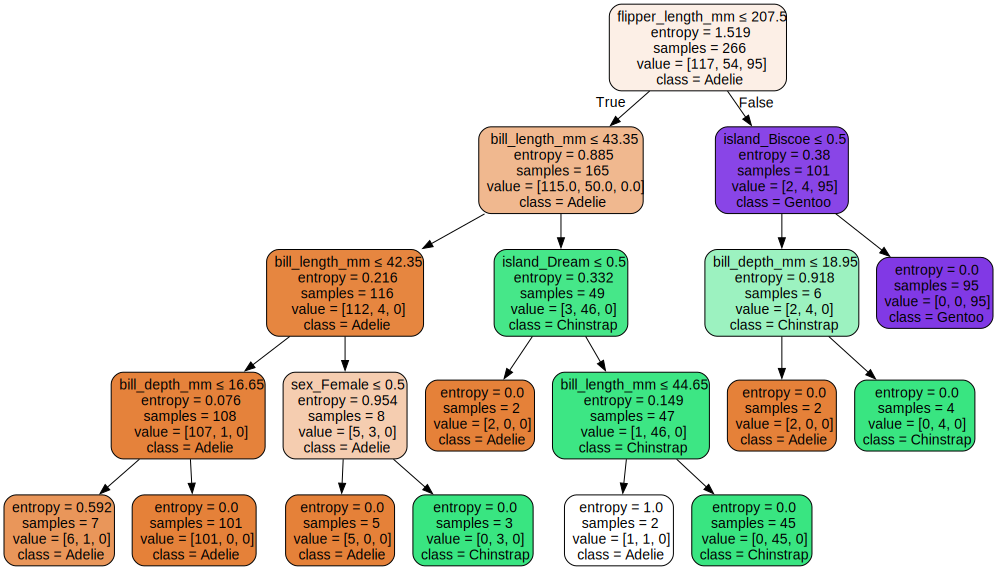

--------------------------------------------------
Độ sâu = 5, Độ chính xác trên tập Test = 0.9254
Cây quyết định với Độ sâu = 5


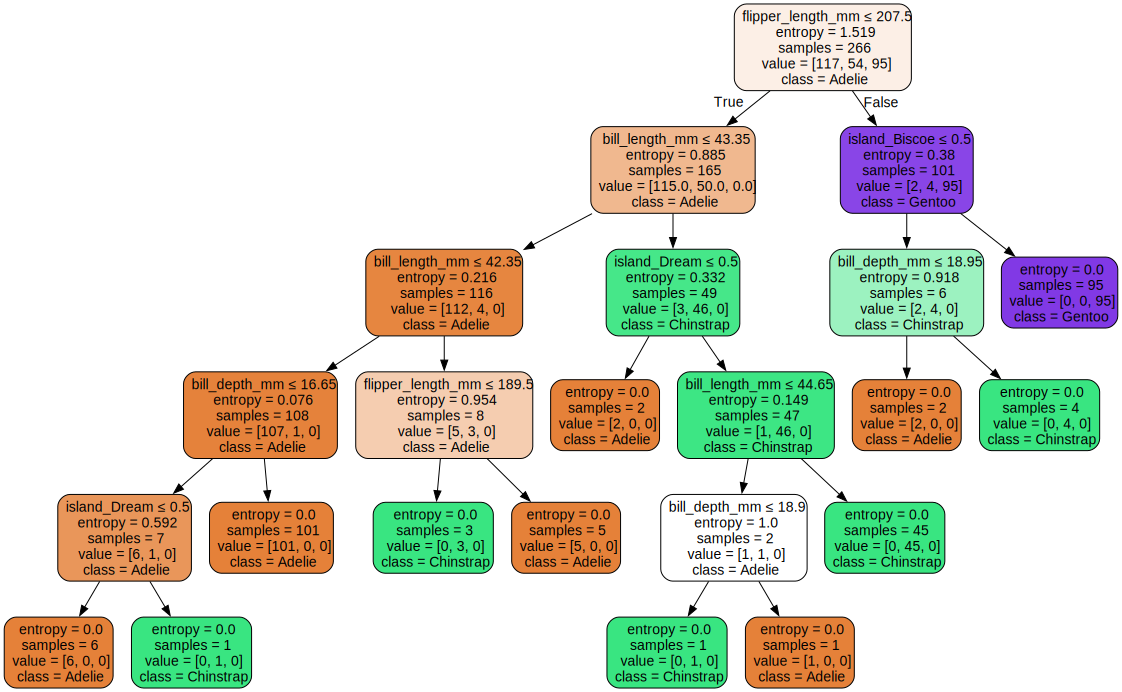

--------------------------------------------------
Độ sâu = 6, Độ chính xác trên tập Test = 0.9254
Cây quyết định với Độ sâu = 6


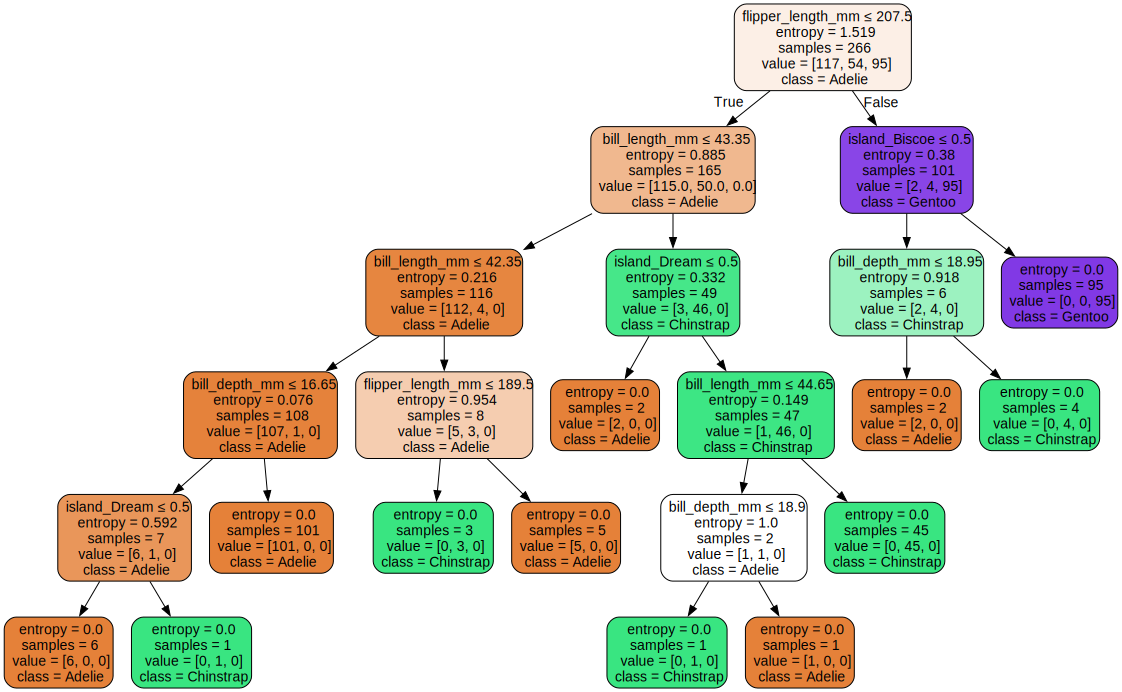

--------------------------------------------------
Độ sâu = 7, Độ chính xác trên tập Test = 0.9254
Cây quyết định với Độ sâu = 7


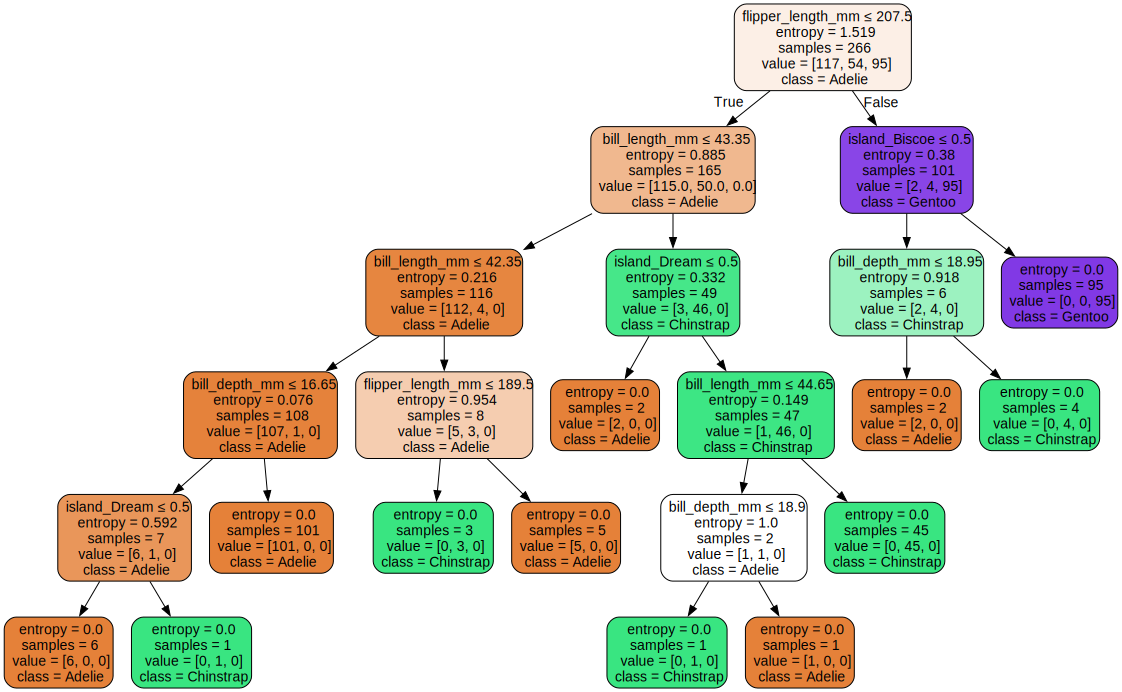

--------------------------------------------------

------ Bảng Tổng hợp Độ chính xác theo Độ sâu ------
  Độ sâu Tối đa (max_depth)  Độ chính xác (Accuracy)
0                      None                 0.925373
1                         2                 0.940299
2                         3                 0.955224
3                         4                 0.970149
4                         5                 0.925373
5                         6                 0.925373
6                         7                 0.925373


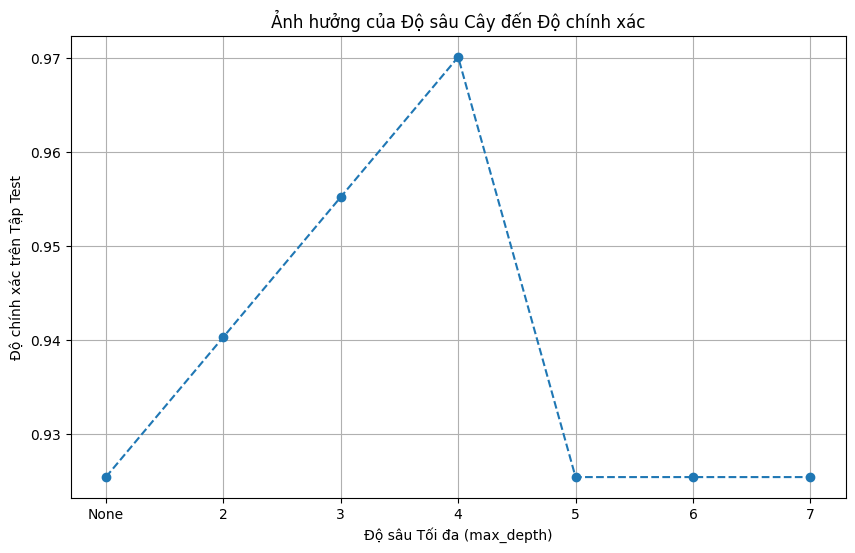

In [11]:
# Cố định tỷ lệ chia 80/20
feature_train, feature_test, label_train, label_test = train_test_split(
    X, y, train_size=0.8, random_state=42, stratify=y
)

# Danh sách các độ sâu cần thử nghiệm
depths = [None, 2, 3, 4, 5, 6, 7]
accuracy_scores = []

print("Bắt đầu thí nghiệm về độ sâu của cây trên tập 80/20...\n")

for depth in depths:
    # Xây dựng mô hình với độ sâu tương ứng
    model = build_pipeline(max_depth=depth)
    model.fit(feature_train, label_train)
    
    # Dự đoán và tính độ chính xác
    label_pred = model.predict(feature_test)
    accuracy = accuracy_score(label_test, label_pred)
    accuracy_scores.append(accuracy)
    
    depth_str = "Tối đa (None)" if depth is None else str(depth)
    print(f"Độ sâu = {depth_str}, Độ chính xác trên tập Test = {accuracy:.4f}")

    # ====== Trực quan hóa cây cho từng độ sâu ======
    feature_names_processed = numerical_cols + list(
        model.named_steps['preprocessor']
        .named_transformers_['cat']
        .named_steps['onehot']
        .get_feature_names_out(categorical_cols)
    )
    dot_data = export_graphviz(
        model.named_steps["classifier"],
        out_file=None, feature_names=feature_names_processed,
        class_names=sorted(y.unique()), filled=True, rounded=True,
        special_characters=True
    )
    print(f"Cây quyết định với Độ sâu = {depth_str}")
    display(graphviz.Source(dot_data))
    print("-" * 50)


# ====== Trình bày kết quả dưới dạng bảng và biểu đồ ======

# Bảng kết quả
depth_labels = ['None' if d is None else str(d) for d in depths]
results_df = pd.DataFrame({
    'Độ sâu Tối đa (max_depth)': depth_labels,
    'Độ chính xác (Accuracy)': accuracy_scores
})
print("\n------ Bảng Tổng hợp Độ chính xác theo Độ sâu ------")
print(results_df)


# Biểu đồ đường
plt.figure(figsize=(10, 6))
plt.plot(depth_labels, accuracy_scores, marker='o', linestyle='--')
plt.title('Ảnh hưởng của Độ sâu Cây đến Độ chính xác')
plt.xlabel('Độ sâu Tối đa (max_depth)')
plt.ylabel('Độ chính xác trên Tập Test')
plt.grid(True)
plt.show()

